# Agent Streaming and Structured Responses

Master agent streaming modes and structured outputs.

**What you'll learn:**
- Agent streaming: messages, updates, values modes
- Structured output: Type-safe responses with Pydantic

#### Agent Streaming Modes

| Mode | Use Case | Returns |
|------|----------|---------|
| **messages** | Real-time token display | Individual message chunks as generated |
| **updates** | Debugging agent flow | Node name + output after each node executes |
| **values** | Track full state | Complete state snapshot after each step |

In [1]:
import sys
sys.path.append('../')

import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.agents import create_agent
from langchain.messages import HumanMessage
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3
from scripts import base_tools

In [3]:
model = ChatGoogleGenerativeAI(model='gemini-2.5-flash')

conn = sqlite3.connect("db/5_streaming_agent.db", check_same_thread=False)
checkpointer = SqliteSaver(conn)

agent = create_agent(
    model=model,
    tools=[base_tools.web_search, base_tools.get_weather],
    checkpointer=checkpointer
)

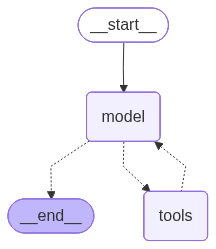

In [4]:
agent

In [5]:
config = {'configurable': {'thread_id': '05_session_1'}}
response = agent.invoke({'messages': [HumanMessage('what is the weather in Mumbai?')]}, config=config)
response

{'messages': [HumanMessage(content='what is the weather in Mumbai?', additional_kwargs={}, response_metadata={}, id='25e07f5e-d1e3-4214-a9b1-e35bf82dcb7f'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"location": "Mumbai"}'}, '__gemini_function_call_thought_signatures__': {'8e1a3ef1-0f79-430f-93d7-9c1c8c80a60f': 'CpkCAXLI2nxJsoc7TXLZojR1H3eRHxi7Whu+TG7Y41udw/6J+ed4Z0SCboX6LTiavN98Kuv1afgM521OMNdEdJgp+3oxYmTfRdwvY9pS18Mgh9kxyUvg5rztd+vlWrBYc7/PxW/Pnv+rU+iObcbmh91ant0AB+J4BeISbmvcxWZ7qYMx/exYek+WpSgq0HL3iD8LdYHvlbRsPOz8ZYXhyS6iXwobDRsjWIlr5nwhMx45vEXtMXW0b/OraGXdPZGksQmHMS8tf1z+yGPLDuvAkos/sD7wbN3WsUMkxOrra4d712UtEkdFwoTNWzb/GHOYktwBJewKyhIx+i3Y4eJYwgqVO85CkFbz712gdO2HZjeIYJUztOVe41qk8io='}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bc557-c418-7693-898a-76ede49f1ae1-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 

In [6]:
# stream mode =  messages
for chunk in agent.stream(
    {'messages': [HumanMessage('what is the weather in Mumbai?')]},
    config=config,
    stream_mode='messages'):

    print(chunk)


(AIMessageChunk(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"location": "Mumbai"}'}, '__gemini_function_call_thought_signatures__': {'ef821e95-4a15-4aec-bc6c-5eccf753d3ad': 'CiQBcsjafH/FWJaslk05SvEVKHHq+GmHIsGm9CUsU98bphbrn2oKYgFyyNp8Tg5N3vdFMKfgzDOejAKABm4fRR5e1N9vkb4Qvd7rzFK40//JA3ezvG2W+r8nnLPJvjdAzGlzj9VCfODA89HHmTexzxgp2K+15K4oP5WgoQCnmieQaDKfipnPOFJXCtIBAXLI2nwMEXTajKq/TFqZR3bVAE/JKE328dABEK/6oCM6m3Y5+8wb/6PJzvL6cHJZXRZrK8lUsKCEI9JmVQ1KzTgKPWeYANvAncZm7MtGKtVD6ePgSMtUgwO7WLFzyT+4QJVMU+js+P3afCB6/ZyHC96snXczl/e1ATz5JBVgpeFQiotWFW3KMCwIcKilCZQWB464WCPVLuGzEteLMa27LFxPm3qJk26x+C26WiSfBlhpbrJaygDpaGGYIThU62JWWos/zpN5/hwndwh8Sj3ZUv+F'}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bc590-2601-7831-8867-e2b9324b7bf0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Mumbai'}, 'id': 'ef821e95-4a15-4aec-bc6c-5eccf753d3ad', 'type': 't

In [7]:
# stream mode =  updates
for chunk in agent.stream(
    {'messages': [HumanMessage('what is the weather in Mumbai?')]},
    config=config,
    stream_mode='updates'):

    print(chunk)

{'model': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"location": "Mumbai"}'}, '__gemini_function_call_thought_signatures__': {'7e5a75df-0c57-4a9a-a9bd-a5a312356214': 'CpQCAXLI2nzo6RfJ4rGGGTptUjcssk2EJDA63h2Q2p2G3hhqofdizJ3QZ/VUAmzT3Ucb1x3JPYB6NVv7oZQ2xC4z62MZfpDeIRIdyGRnTBrvB8ghEyFmvBpM6eUmprZt0/oqOg8bgaei4eR6zM8fS4u40gjQiYIicPBKj9mQ6gDPjFXCsYWBMUZzBlKFe8jaWSL/UA5Spk0b+9w1o0iAm+oL69/YWg5MhvcFiiPtAS/Y24ShJncCHXmR5lNlMJL5Lk3XgzhzxZ4J7ED45AWshAgZ5gMvlp4fFo7Ica+FIzhspdveSLVzHJhR7hU59LaGntC6nGc6KF/6OMrONUDE6Ws+CZa8LghniBkQxwpcdZ7SQzUOuqAy'}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bc590-3295-71d0-aeda-07b472a14a95-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Mumbai'}, 'id': '7e5a75df-0c57-4a9a-a9bd-a5a312356214', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 5338, 'o

In [8]:
# stream mode =  values
config = {'configurable': {'thread_id': '05_session_2'}}

for chunk in agent.stream(
    {'messages': [HumanMessage('what is the weather in Mumbai?')]},
    config=config,
    stream_mode='values'):

    print(chunk)

{'messages': [HumanMessage(content='what is the weather in Mumbai?', additional_kwargs={}, response_metadata={}, id='f723aa36-3905-4d1a-9281-36c9bf8396c7'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"location": "Mumbai"}'}, '__gemini_function_call_thought_signatures__': {'c8ba64ff-a275-454f-9527-f1c8aaaeba52': 'CrACAXLI2nwfdzJg7TThtYdhGmcMGUgXat1EWydfZh7tODco3h006Fq96otGTfBlXy/qbCjsncltpceRM7mG0e3clmA1ZwgumYczbYjaSK5SeG5uj/vNYXLLOfQUI5lPZEee+p/BS42gUvh7N1rCGflhFSTzmvxTbork9aHCot1g2mpdBdeIrHDUh3Dk/gVSJ6ImnJqfYQd4o9x2zJnTK8plcjVzI3mZ3rpb0kgMPaydUr1FAtb8lP1tDlbZd/yDDPB1BCvGp44ij25Dw/e7wvHYy0/6Ix5gpudYy3G1duZuewae1h04EsHDWLRbaSthEcZ1ouPnzwnr4zlCEtNfx3QBIuQFrZBl9H2Ard3vPliu12OQdrSJPpVNuzKS4nRsrhLdbsRzrZ0pqMm9TQprX4o4cQ=='}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bc56d-906b-7421-993e-ec68fcc8d1ed-0', tool_calls=[{'name': 'get_w

In [9]:
from scripts import agent_utils

agent_utils.stream_agent_response(agent, 'what is the weather in mumbai', '5_session_3')


  Tool Called: get_weather
   Args: {'location': 'Mumbai'}


  Tool Response: {"location": {"name": "Mumbai", "region": "Maharas...

  Tool Result (length: 858 chars)

The weather in Mumbai is 30.1°C and it is overcast. The wind speed is 7.9 kph in the WNW direction. The humidity is 55% and the UV index is 7.1.

In [10]:
agent_utils.stream_agent_response(agent, 'tell me latest news about Apple stock and BTC', '5_session_3')


  Tool Called: web_search
   Args: {'query': 'Apple stock news'}


  Tool Called: web_search
   Args: {'query': 'BTC news'}


  Tool Response: [WebSearchResult(content="AAPL: Apple Inc - Stock ...

  Tool Result (length: 10081 chars)


  Tool Response: [WebSearchResult(content="Bitcoin price news: BTC ...

  Tool Result (length: 27161 chars)

Here's the latest news on Apple stock and BTC:

**Apple Stock (AAPL):**
Apple (AAPL) closed at 259.96, down 0.42%. Recent news includes an investigation into Elon Musk's xAI regarding deepfake images, Google's new Personal Intelligence feature in the Gemini app posing a challenge to Apple, and a collaboration between Apple and Google on AI. Other reports mention analysts' calls on Apple, Airbnb hiring a former Meta GenAI leader, and Jim Cramer's top stock picks.

**Bitcoin (BTC):**
Bitcoin is currently experiencing a sell-off during U.S. market hours, falling below $96,000. This follows a recent rally that saw its price reach just under $98,000. 

## Structured Output

In [11]:
from pydantic import BaseModel, Field
from typing import Optional

class FinancialAnalysis(BaseModel):
    company: str = Field(description="Company name")
    stock_symbol: str = Field(description="Stock ticker")
    current_price: Optional[str] = Field(description="Current price", default=None)
    analysis: str = Field(description="Brief analysis")
    recommendation: str = Field(description="Buy/Hold/Sell")

In [12]:
agent = create_agent(
    model=model,
    tools=[base_tools.web_search],
    response_format=FinancialAnalysis
)

In [13]:
response = agent.invoke({'messages': [HumanMessage('tell me latest news about Apple stock')]})

In [16]:
response['structured_response'].model_dump()

{'company': 'Apple Inc.',
 'stock_symbol': 'AAPL',
 'current_price': 'Around $212.49 - $259.96',
 'analysis': "Apple stock (AAPL) saw a slight decline, closing at around $212.49 (Yahoo Finance) or $259.96 (CNBC) and continuing to dip slightly in after-hours trading. Recent news highlights Apple's competition with Google in AI, with Google launching a new Personal Intelligence feature in its Gemini app, and a past report (Jan 13, 2026) of Apple and Google teaming up on AI. Apple, along with Nvidia and Microsoft, is noted for fueling the Nasdaq amid a divided market rally. Analysts have also included Apple in their recent calls.",
 'recommendation': 'Hold'}